# Forecasting #

In [1]:
# imports
import pandas as pd
import numpy as np
import time

In [2]:
# define data location
# location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

In [3]:
# load data
granularity = "daily"

if granularity == "daily":
    test = pd.read_pickle(location+'fcast_daily.pkl.zip') # 2 years of data
    train = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip') # most recent year, id/date sufficiency
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    codebook = pd.read_pickle(location+'codebook.pkl.zip')
elif granularity == "hourly":
    test = pd.read_pickle(location+'fcast_hourly.pkl.zip') # 2 years of data
    train = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip') # most recent year, id/date sufficiency
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    codebook = pd.read_pickle(location+'codebook.pkl.zip')
else:
    print("Granularity not in ('daily','hourly')")

In [4]:
# testing dates are the older year
test = test[test['Dt'] < "10-1-2017"]

## Forecast by Rate Code (TARIFF) ##

### Train ###

In [ ]:
# calculate cluster centroids
data = train[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('TARIFF').mean().reset_index()

In [ ]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [ ]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

In [ ]:
# Treat tariff as kmeans cluster
# Build regression model per tariff centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if granularity == 'daily':
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
elif granularity == 'hourly':
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']

# save model and equation for each cluster
models = []
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

In [ ]:
rTable

### Test ###

In [ ]:
# calculate cluster centroids
data = test[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','TARIFF']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('TARIFF').mean().reset_index()

In [ ]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='TARIFF',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [ ]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather,
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

In [ ]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

code_error = pd.DataFrame(columns=['Acts','Preds'])

for code in centroids_clust['TARIFF'].unique():
    data = centroids_clust[(centroids_clust['TARIFF']==code)]
    X = data[data['TARIFF']==code][features]
    y = data[data['TARIFF']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    
    err = pd.DataFrame({'Acts':y, 'Preds':yhat})
    code_error = code_error.append(err)
    del (data, X, y)

In [17]:
def errfn (acts, preds, method):
    """
    Calculates error using a variety of functions, 
    incl. Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), & Log Accuracy Ratio (LNQ)
    SMAPE is Symmetric Mean Average Percentage Error. Note: A limitation to SMAPE is that if the actual value or forecast value is 0, the value of error will boom up to the upper-limit of error.
    LnQ acts as an improved SMAPE metric when all values are positive.  See: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2635088

    Parameters
    ----------
    acts : actual values (ground truth) in list or numpy array
    preds : predicted values  in list or numpy array
    method : error function, including RMSE, MAE, SMAPE, LnQ

    Returns
    ----------
    error : float

    @author: Yi Zhu, Alex Graber
    """

    # force method to uppercase
    method = method.upper()
    
    # check to ensure equal length vectors
    if (len(acts) != len(preds)):
        print("Abs and Preds do not have equivalent length!")
    
    # param detection
    if (method == "RMSE"): 
        #calculate RMSE
        from math import sqrt
        from sklearn.metrics import mean_squared_error
        error = sqrt(mean_squared_error(acts, preds))
    elif (method == "MAE"):
        #calculate MAE
        from sklearn.metrics import mean_absolute_error
        error = mean_absolute_error(acts, preds)
    elif (method == "SMAPE"):
        #calculate SMAPE
        numerator = abs(preds-acts)
        #denominator = (abs(acts) + abs(preds))/2
        denominator = (acts+preds)
        error = np.sum(numerator)/np.sum(denominator)
    elif (method == "LNQ"):
        #calculate LnQ
        error = np.sum(np.log(preds/acts)**2)
    else:
        print("Attempted method not in [RMSE, MAE, SMAPE,LNQ]")

    return error

In [ ]:
code_error[code_error['Preds']<0]

In [ ]:
# calculate error
rmse = errfn(code_error['Acts'], code_error['Preds'], 'RMSE')
mae = errfn(code_error['Acts'], code_error['Preds'], 'MAE')
smape = errfn(code_error['Acts'], code_error['Preds'], 'SMAPE')
lnq = errfn(code_error['Acts'], code_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

## Forecast by Cluster ##

In [80]:
# temp
codebook = pd.read_pickle(location+'codebook.pkl.zip')

### Train ###

In [81]:
# calculate cluster centroids
data = train[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()

In [82]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [83]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,Cluster,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,H_H,2017-10-12,6.667451,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
1,H_L,2017-10-12,156.557727,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
2,H_M,2017-10-12,288.511194,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
3,L_H,2017-10-12,0.509154,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
4,L_L,2017-10-12,1.456000,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667


In [84]:
# Treat cluster as kmeans cluster
# Build regression model per cluster centroid
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from itertools import chain
from timeit import default_timer as timer

if granularity == 'daily':
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
elif granularity == 'hourly':
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']

# save model and equation for each cluster
models = []
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))

for code in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==code)]
    X = data[data['Cluster']==code][features]
    y = data[data['Cluster']==code]['Use']
    
    # fit the regression model
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X, y)
    models.append((code,regr))
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[code] = [intercept]+list(chain(coefs))+[err]+[r2]
    del (data, X, y)

models = dict(models)
rTable = rTable.T

In [85]:
rTable

,intercept,LowDB1,LowDB1delta,MSE,R2
H_H,108.944664,-1.606828,-1.344737,113.351286,0.878386
H_L,-19.034364,2.356889,0.772980,14011.352124,0.111708
H_M,435.620355,-4.081494,-5.118270,2741.792072,0.668355
L_H,8.453418,-0.123248,-0.106364,0.712288,0.871358
L_L,1.826977,-0.002311,-0.014049,1.377063,0.005637
L_M,6.416577,-0.073648,-0.064970,1.015249,0.629511
M_H,16.894996,-0.250451,-0.217397,2.909993,0.872590
M_L,7.885980,-0.028143,-0.034576,0.846972,0.236045
M_M,10.321453,-0.089144,-0.059671,0.425030,0.854832
N_H,3.353621,-0.048915,-0.041162,0.171699,0.815500


### Test ###

In [86]:
# Identify Clusters in Test data
use = test[['ID','Use']].groupby('ID').mean().reset_index()

use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
use.loc[ use.Use > 10, 'UseGroup'] = 3

# look at whether there's a difference in use between cold months and warm months (i.e., is there gas heat?)
test['coldmonths'] = pd.get_dummies((test['Dt'].dt.month <= 2) | (test['Dt'].dt.month >= 11))[True]
test['warmmonths'] = pd.get_dummies((test['Dt'].dt.month >= 6) & (test['Dt'].dt.month <= 9))[True]

cold = (test[test['coldmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'colduse'}))
warm = (test[test['warmmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'warmuse'}))
total = (test[(test['coldmonths']==1) | (test['warmmonths']==1)][['ID','Use']]
         .groupby('ID').sum().reset_index()
         .rename(columns={'Use':'totaluse'}))
test = test.drop(columns=['coldmonths','warmmonths'])

gasheat = cold.merge(warm, how='inner', on='ID').merge(total, how='inner', on='ID')
gasheat['pctcold'] = gasheat['colduse']/gasheat['totaluse']
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .5, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .5) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2


codebook = (test[['ID','TARIFF']].drop_duplicates()
            .merge(use[['ID','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID'))

codebook['Cluster'] = None
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter

del (use,cold,warm,total,gasheat)

In [87]:
# calculate cluster centroids
data = test[['ID','Dt','Use']].pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()

In [88]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] =  pd.to_datetime(centroids['Dt'])

In [89]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather,
                           how='inner', on='Dt')

del (data, centroids)
centroids_clust.head()

,Cluster,Dt,Use,AvgTemp,HighDB,LowDB,Temp1,Temp1delta,HighDB1,HighDB1delta,...,AvgHumid,Humid1,Humid1delta,AvgWind,Wind1,Wind1delta,AvgDaytimeCloud,AvgCloud,Cloud1,Cloud1delta
0,H_M,2016-10-01,243.39,61.125000,64,58,60.125000,1.000000,63.0,1.0,...,90.666667,91.041667,-0.375000,11.000000,15.208333,-4.208333,100.000000,100.000000,100.000000,0.000000
1,H_M,2016-10-02,223.09,63.458333,67,61,61.125000,2.333333,64.0,3.0,...,90.875000,90.666667,0.208333,5.500000,11.000000,-5.500000,95.000000,96.250000,100.000000,-3.750000
2,H_M,2016-10-03,174.88,67.208333,76,63,63.458333,3.750000,67.0,9.0,...,74.500000,90.875000,-16.375000,4.625000,5.500000,-0.875000,54.166667,62.500000,96.250000,-33.750000
3,H_M,2016-10-04,214.29,62.833333,68,59,67.208333,-4.375000,76.0,-8.0,...,79.291667,74.500000,4.791667,7.666667,4.625000,3.041667,90.000000,64.583333,62.500000,2.083333
4,H_M,2016-10-05,223.77,61.750000,71,56,62.833333,-1.083333,68.0,3.0,...,70.458333,79.291667,-8.833333,8.500000,7.666667,0.833333,27.500000,31.250000,64.583333,-33.333333


In [90]:
# For each tariff, forecast subsequent year of use
from sklearn import linear_model

from itertools import chain
from timeit import default_timer as timer

clust_error = pd.DataFrame(columns=['Acts','Preds'])

for code in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==code)]
    X = data[data['Cluster']==code][features]
    y = data[data['Cluster']==code]['Use']
    
    regr = models[code]
    yhat = regr.predict(X)
    
    err = pd.DataFrame({'Acts':y, 'Preds':yhat})
    clust_error = clust_error.append(err)
    del (data, X, y)

In [91]:
# calculate error
rmse = errfn(clust_error['Acts'], clust_error['Preds'], 'RMSE')
mae = errfn(clust_error['Acts'], clust_error['Preds'], 'MAE')
smape = errfn(clust_error['Acts'], clust_error['Preds'], 'SMAPE')
lnq = errfn(clust_error['Acts'], clust_error['Preds'], 'LNQ')
print("RMSE: ", rmse, "\nMAE: ", mae, "\nSMAPE: ", smape, "\nLNQ: ",lnq)
# lnq inf means we have negative predictions

RMSE:  46.86691335234204 
MAE:  37.890884557728135 
SMAPE:  0.07779954168070555 
LNQ:  17.525591639858007


### compare errors ###

In [170]:
# calculate errors
code_error['code_error'] = code_error['Acts']-code_error['Preds']
clust_error['seg_error'] = clust_error['Acts']-clust_error['Preds']

print(code_error['code_error'].var(), clust_error['seg_error'].var())

51406.93827545474 1436.6783705875064


In [171]:
#ttest for independence
from scipy import stats
stats.ttest_ind(code_error['code_error'], clust_error['seg_error'], equal_var = False)

Ttest_indResult(statistic=-12.50850535946029, pvalue=2.3590155293685016e-30)

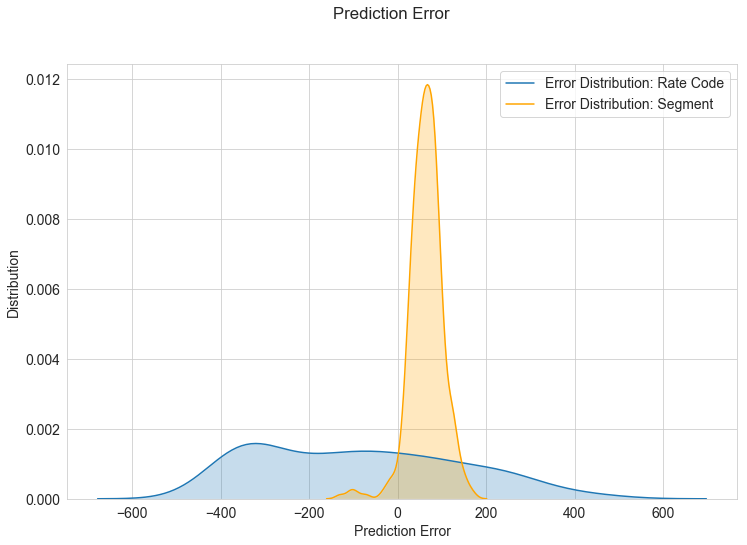

In [172]:
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(figsize=(12,8))
sns.set_style('whitegrid')
fig.suptitle('Prediction Error')

sns.kdeplot(code_error['code_error'], label='Error Distribution: Rate Code', shade=True);
sns.kdeplot(clust_error['seg_error'], label='Error Distribution: Segment', shade=True, color="orange")
plt.xlabel('Prediction Error'); plt.ylabel('Distribution'); 

# save
fig.savefig(location+'error_dist.png')